### Exercise 1a

Implement an adaptive step size control feature in Runge-Kutta-Fehlberg 5th order integration routine.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from code.plot_utils import plot_pretty

plot_pretty()

In [2]:
###### Runge-Kutta-Fehlberg 5th-4th order scheme for a single step

# Coefficients used to compute the independent variable argument of f
c20  =   2.500000000000000e-01  #  1/4
c30  =   3.750000000000000e-01  #  3/8
c40  =   9.230769230769231e-01  #  12/13
c50  =   1.000000000000000e+00  #  1
c60  =   5.000000000000000e-01  #  1/2

# Coefficients used to compute the dependent variable argument of f
c21 =   2.500000000000000e-01  #  1/4
c31 =   9.375000000000000e-02  #  3/32
c32 =   2.812500000000000e-01  #  9/32
c41 =   8.793809740555303e-01  #  1932/2197
c42 =  -3.277196176604461e+00  # -7200/2197
c43 =   3.320892125625853e+00  #  7296/2197
c51 =   2.032407407407407e+00  #  439/216
c52 =  -8.000000000000000e+00  # -8
c53 =   7.173489278752436e+00  #  3680/513
c54 =  -2.058966861598441e-01  # -845/4104
c61 =  -2.962962962962963e-01  # -8/27
c62 =   2.000000000000000e+00  #  2
c63 =  -1.381676413255361e+00  # -3544/2565
c64 =   4.529727095516569e-01  #  1859/4104
c65 =  -2.750000000000000e-01  # -11/40

# Coefficients used to compute 4th order RK estimate
a1  =   1.157407407407407e-01  #  25/216
a2  =   0.000000000000000e-00  #  0
a3  =   5.489278752436647e-01  #  1408/2565
a4  =   5.353313840155945e-01  #  2197/4104
a5  =  -2.000000000000000e-01  # -1/5
# Coefficients used to compute 5th order RK estimate
b1  =   1.185185185185185e-01  #  16.0/135.0
b2  =   0.000000000000000e-00  #  0
b3  =   5.189863547758284e-01  #  6656.0/12825.0
b4  =   5.061314903420167e-01  #  28561.0/56430.0
b5  =  -1.800000000000000e-01  # -9.0/50.0
b6  =   3.636363636363636e-02  #  2.0/55.0
# coefficients for the error (difference between 5th and 4th order)
e1 = b1-a1; e3 = b3-a3; e4 = b4-a4; e5 = b5-a5

def rkf45_onestep(f, y_start, t_start, h, *args):
    """
    5th order accurate embedded Runge-Kutta-Fehlberg scheme with constant step (i.e. non adaptive) 
    to solve ode dy/dt = f(t,y)
    
    The scheme simultaneously computes RK schemes of 4th and 5th order, which
    can be used to estimate the local error of the calculation, which can be used 
    for adaptive step control
    
    Parameters: 
    ----------------------------------------------------------------------------
    f - function object
              f(t, y, *args)
    y_start - float or vector of floats for system of equations
              initial value of y at t_start
    t_start - float 
              starting time
    t_end   - float
              end time
    h       - float
              integration step
    *args   - python list
              list of arguments to pass to f
              
    Returns:  
    ----------------------------------------------------------------------------
    ynh     - numpy float array
              next step (t_start+h) solution
    e       - numpy float array
              error: 4rth and 5th order solution difference
    """
    
    nl = 4; nh = 1
    t, ynh = t_start, y_start; 

    w = 0.8
    #construct solutions of the 4th order and error (difference of 5th and 4th order)
    k1 = h * f(t, ynh, *args)
    k2 = h * f(t + c20*h, ynh + c21 * k1, *args)
    k3 = h * f(t + c30*h, ynh + c31 * k1 + c32 * k2, *args)
    k4 = h * f(t + c40*h, ynh + c41*k1 + c42*k2 + c43*k3, *args)
    k5 = h * f(t + h    , ynh + c51*k1 + c52*k2 + c53*k3 + c54*k4, *args)
    k6 = h * f(t + c60*h, ynh + c61*k1 + c62*k2 + c63*k3 + c64*k4 + c65*k5, *args)
    # 4th order solution
    ynl  = a1 * k1 + a3 * k3 + a4 * k4 + a5 * k5
    # 5th order solution
    ynh += b1 * k1 + b3 * k3 + b4 * k4 + b5 * k5 + b6 * k6
    # absolute difference between 4th and 5th order solutions
    e = np.abs( b6*k6 + e1*k1 + e3*k3 + e4*k4 + e5*k5 )
    return ynh, e

In [3]:
###### Runge-Kutta-Fehlberg 5th-4th order scheme that is combined to determine step size adaptively
def rkf45(f, y_start, t_start, t_end, h, atol, rtol, *args):
    """
    5th order accurate embedded Runge-Kutta-Fehlberg scheme with constant step (i.e. non adaptive) 
    to solve ode dy/dt = f(t,y)
    
    The scheme simultaneously computes RK schemes of 4th and 5th order, which
    can be used to estimate the local error of the calculation, which can be used 
    for adaptive step control
    
    Parameters: 
    ----------------------------------------------------------------------------
    f - function object
              f(t, y, *args)
    y_start - float or vector of floats for system of equations
              initial value of y at t_start
    t_start - float 
              starting time
    t_end   - float
              end time
    h       - float
              integration step
    *args   - python list
              list of arguments to pass to f
              
    Returns:  
    ----------------------------------------------------------------------------
    tout     - numpy float array
               time of each step 
    yout     - numpy float array
               solution y(tout)
    """
    
    w = 0.9
    nl = 4; nh = 1
    t, ynh = t_start, y_start; 
    tout = np.array(t); yout = np.array(ynh)

    # check if initial step size can be used to achieve accuracy rtol
    # if not make it smaller (or larger if we can afford it)
    ynh_init, e_init = rkf45_onestep(dydt, y_start, t_start, h, tau1, tau2)
    etol_init = atol + rtol*np.abs(ynh_init)
    if e_init > etol_init:
        while e_init > etol_init:
            # new step size = h*(etol/e)^(1/(nl+1))
            fact = (etol_init/e_init)**(1/(nl+1))
            h *= w*fact
            ynh_init, e_init = rkf45_onestep(dydt, ynh, t, h, tau1, tau2)
            etol_init = atol + rtol*np.abs(ynh_init)
    elif e_init < 0.1*etol_init:
        h *= 1.1
    
    # start intrgration with step size determined above
    while t < t_end:
        ynh, e = rkf45_onestep(dydt, ynh, t, h, tau1, tau2)
        etol = atol + rtol*np.abs(ynh)
        # check condition e < etol
        if e > etol:
            while e > etol:
                # new step size = h*(etol/e)^(1/(nl+1))
                fact = (etol/e)**(1/(nl+1))
                h *= w*fact
                ynh, e = rkf45_onestep(dydt, ynh, t, h, tau1, tau2)
                etol = atol + rtol*np.abs(ynh)
        elif e < 0.1*etol:
            h *= 1.1
        t += h
        tout = np.vstack((tout,t)); yout = np.vstack((yout,ynh))
    return tout, yout

The equation we will test the above routine with is the following,
$$\frac{dy}{dt} = \frac{e^{-t/\tau_1}}{\tau_1} - \frac{e^{-t/\tau_2}}{\tau_2} = e^{-t/\tau_2} \left( \frac{1}{\tau_1} - \frac{1}{\tau_2} \right) - \frac{y}{\tau_1} \; ,$$
where 
$$y = c - e^{-t/\tau_1} + e^{-t/\tau_2}$$
is the analytic solution, where $c$ is a constant. The initial condition is $y(t=0)=0$ which leads to $c = 0$ and thus
$$y(t=1) = e^{-1/\tau_2} + e^{-1/\tau_1} \; .$$

In [4]:
# differential equation to solve: dy/dt = f(t,y)
def dydt(t, y, tau1, tau2, *args):
    return (1./tau1 - 1./tau2)*np.exp(-t/tau2) - y/tau1

# exact analytic solution
def yexact(t, tau1, tau2, *args):
    return np.exp(-t/tau2) - np.exp(-t/tau1)

In [5]:
""" 
    Testing rkf45 with adaptive step size control.
    We test our rkf45 routine by solving the differential equation with various rtol values
    and comparing the results with the exact solution, yexact, by ploting the absolute value of 
    their fractional error for each case, as a function of time.
"""
# parameters
tau1 = 0.001; tau2 = 1.
t_start = 1.; t_end = 5.
y_start = yexact(t_start, tau1, tau2)

# error tolerance
atol = 1.e-10
rtol1 = 1.e-6
rtol2 = 1.e-10

In [6]:
### solutions for initial step size h>2*tau1 for rtol=1e-6 (solution ysol11) and rtol=1e-10 (solution ysol12)
# initial step size
h1 = 6.7*tau1
# rkf45 solutions
t11, ysol11 = rkf45(dydt, y_start, t_start, t_end, h1, atol, rtol1, tau1, tau2)
t12, ysol12 = rkf45(dydt, y_start, t_start, t_end, h1, atol, rtol2, tau1, tau2)

# fractional errors
frerr11 = np.abs(ysol11[1:] - yexact(t11[1:], tau1, tau2))/yexact(t11[1:], tau1, tau2)
frerr12 = np.abs(ysol12[1:] - yexact(t12[1:], tau1, tau2))/yexact(t12[1:], tau1, tau2)
##########################################################################################

### solutions for initial step size h<2*tau1 for rtol=1e-6 (solution ysol21) and rtol=1e-10 (solution ysol22)
# initial step size
h2 = 1.*tau1
# rkf45 solutions
t21, ysol21 = rkf45(dydt, y_start, t_start, t_end, h2, atol, rtol1, tau1, tau2)
t22, ysol22 = rkf45(dydt, y_start, t_start, t_end, h2, atol, rtol2, tau1, tau2)

# fractional errors
frerr21 = np.abs(ysol21[1:] - yexact(t21[1:], tau1, tau2))/yexact(t21[1:], tau1, tau2)
frerr22 = np.abs(ysol22[1:] - yexact(t22[1:], tau1, tau2))/yexact(t22[1:], tau1, tau2)

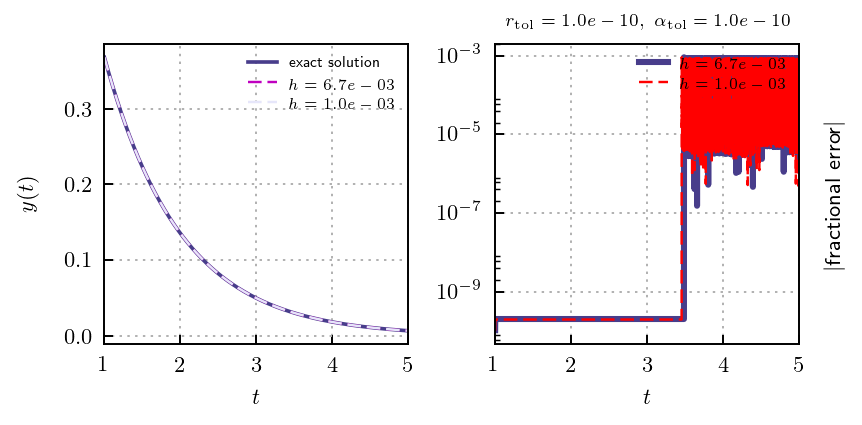

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(5,2.5))

ax[0].set_xlim(t_start, t_end)
ax[0].set_xlabel(r'$t$',labelpad = 5)
ax[0].set_ylabel(r'$y(t)$',labelpad = 10)
ax[0].plot(t11,yexact(t11, tau1, tau2), linewidth=1.5, c='darkslateblue', label=r'exact solution')
ax[0].plot(t12,ysol12, '--', linewidth=1., c='m', label=r'$h = %.1e$'%(6.7*tau1))
ax[0].plot(t22,ysol22, '--', linewidth=1., c='lavender', label=r'$h = %.1e$'%(tau1))

ax[0].legend(loc='upper right', frameon=False, fontsize=6)
ax[0].grid(ls='dotted')

# error
ax[1].set_yscale('log')
ax[1].set_xlim(t_start, t_end)
ax[1].set_xlabel(r'$t$',labelpad = 5)
ax[1].yaxis.set_label_position('right')
ax[1].set_ylabel(r'$|$fractional error$|$',labelpad = 10)
ax[1].plot(t12[1:],frerr12, linewidth=2.5, c='darkslateblue', label=r'$h = %.1e$'%(6.7*tau1))
ax[1].plot(t22[1:],frerr22, '--', linewidth=1, c='r', label=r'$h = %.1e$'%(tau1))
ax[1].legend(loc='upper right', frameon=False, fontsize=6)
ax[1].grid(ls='dotted')

plt.title(r'$r_{\rm tol} = %.1e,\ \alpha_{\rm tol}=%.1e$'%(rtol2, atol), fontsize=7)
plt.tight_layout()
plt.show()

As we can see, for initial step size larger than $2\tau_1$ the solution tends to increase extremele fast at the biginning, but the step-size control we implemented in the rkf45 routine seems to get this under control (until we get to the stiff side if this equation, at least). For initial step size of less than $2\tau_1$ this behaviour is not observes. This is expected from the stability analysis of the given equation which predicts such behavior around $h=2\tau_1$.

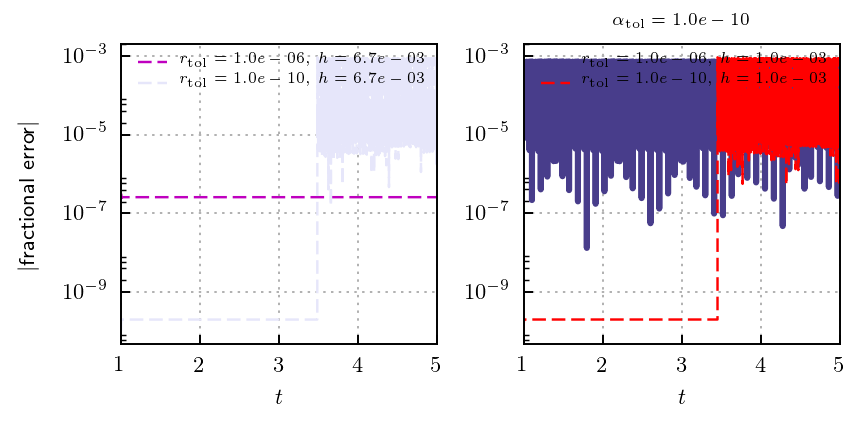

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(5,2.5))

ax[0].set_yscale('log')
ax[0].set_xlim(t_start, t_end)
ax[0].set_xlabel(r'$t$',labelpad = 5)
ax[0].set_ylabel(r'$|$fractional error$|$',labelpad = 10)
ax[0].plot(t11[1:],frerr11, '--', linewidth=1., c='m', label=r'$r_{\rm tol} = %.1e,\ h=%.1e$'%(rtol1, h1))
ax[0].plot(t12[1:],frerr12, '--', linewidth=1., c='lavender', label=r'$r_{\rm tol} = %.1e,\ h=%.1e$'%(rtol2, h1))

ax[0].legend(loc='upper right', frameon=False, fontsize=6)
ax[0].grid(ls='dotted')

# error
ax[1].set_yscale('log')
ax[1].set_xlim(t_start, t_end)
ax[1].set_xlabel(r'$t$',labelpad = 5)
ax[1].yaxis.set_label_position('right')
ax[1].plot(t21[1:],frerr21, linewidth=2.5, c='darkslateblue', label=r'$r_{\rm tol} = %.1e,\ h=%.1e$'%(rtol1, h2))
ax[1].plot(t22[1:],frerr22, '--', linewidth=1, c='r', label=r'$r_{\rm tol} = %.1e,\ h=%.1e$'%(rtol2, h2))
ax[1].legend(loc='upper right', frameon=False, fontsize=6)
ax[1].grid(ls='dotted')

plt.title(r'$\alpha_{\rm tol}=%.1e$'%(atol), fontsize=7)
plt.tight_layout()
plt.show()

Also, after trying two different values of rtol for each initial step size, we can conclude that in general our routine seems to be quite accurate, especially for larger times, and that for smaller intitial step size the results are better.

### Exercise 1b

Testing rkf45 with step-size control with a stiff equation.

In [9]:
""" 
    Testing rkf45 with adaptive step size control for stiff ODE integration.
    We will test the same routine using different parameters that make the given 
    ODE stiff.
"""
# parameters
tau1 = 1.e-10; tau2 = 1.
t_start = 1.; t_end = 5.
y0 = 1. - np.exp(-1/tau2) + np.exp(-1/tau1)
y_start = yexact(t_start, y0, tau1, tau2)

atol = 1.e-10; rtol = 1.e-6; h = 1.e-3

tsol, ysol = rkf45(dydt, y_start, t_start, t_end, h, atol, rtol, y0, tau1, tau2)

KeyboardInterrupt: 

For $\tau_1 = 10^{-10}$ and $\tau_2 = 1$ our previous integrator seems to cannot solve the ODE. The reason for this is the stiffness of the equation due to the term $\tau_1$ which makes the solver to reduce the step size to extremely small values and therefore the code runs for too long without returning a result.

To handle this issue we need to implement implicit schemes. We are going to use the backward Euler method, according to which
$$y_{i+1} = y_i + h f(t_{i+1},y_{i+1}) \; .$$
Thus, for our case we get
$$y_{i+1} = \frac{\tau_1}{h + \tau_1} \left[ y_n + h \left( \frac{1}{\tau_1} - \frac{1}{\tau_2} \right) e^{-t_{i+1}/\tau_2} \right] \; .\;$$
which is 1st order.

Also, we will implemet a higher-order scheme in order to compare it with the above one and get the local error. This scheme will be the trapezoidal, expressed as
$$y_{i+1} = \frac{2\tau_1}{h + 2\tau_1} \left\{ y_n + \frac{h}{2} \left[ f(t_n, y_n) + \left( \frac{1}{\tau_1} - \frac{1}{\tau_2} \right) e^{-t_{i+1}/\tau_2} \right] \right\} \; ,$$
where $f(t,x) = dy/dt$; this is 2nd order.

In [9]:
# 1st-order scheme
def fl(t, y, h, tau1, tau2):
    return (tau1/(h+tau1)) * ( y + h*np.exp(-t/tau2)*(1./tau1 - 1./tau2) )

# 2nd-order scheme
def fh(t, y, h, tau1, tau2):
    return (2.*tau1/(h + 2.*tau1)) * ( y + 0.5*h*dydt(t, y, tau1, tau2) + 0.5*h*np.exp(-t/tau2)*(1./tau1 - 1./tau2) )

In [10]:
""" Implicit scheme using backwards Euler scheme of order 1 and trapezoidal rule of order 2 """

def int_implicit(fl, fh, y_start, t_start, t_end, h, atol, rtol, *args):
    yh = y_start; t = t_start
    tout = np.array(t); yout = np.array(yh)
    
    w = 0.9
    nl = 1; nh = 2
    ### determine step size h ###
    # application of lower-order scheme
    y_init_l = fl(t, yh, h, *args)
    # application of higher-order scheme
    y_init_h = fh(t, yh, h, *args)
    # local error
    e_init = np.abs(y_init_h - y_init_l)
    # fractional error tolerance tolerance
    etol_init = atol + rtol*np.abs(y_init_h)
    if e_init > etol_init:
        while e_init > etol_init:
            fact = (etol_init/e_init)**(1/(nl+1));
            # new step size = h*(etol/e)^(1/(nl+1))
            h *= w*fact
            y_init_l = fl(t, yh, h, *args)
            y_init_h = fh(t, yh, h, *args)
            e_init = np.abs(y_init_h - y_init_l)
            etol_init = atol + rtol*np.abs(y_init_h)
    elif e_init < 0.1*etol_init:
        h *= 1.00001
    
    while t < t_end:
        yl = fl(t, yh, h, *args)
        yh = fh(t, yh, h, *args)
        e = np.abs(yh-yl)
        etol = atol + rtol*np.abs(yh)
        # check condition e < etol
        if e > etol:
            while e > etol:
                fact = (etol/e)**(1/(nl+1));
                # new step size = h*(etol/e)^(1/(nl+1))
                h *= w*fact
                yl = fl(t, yh, h, *args)
                yh = fh(t, yh, h, *args)
                e = np.abs(yh-yl)
                etol = atol + rtol*np.abs(yh)
        elif e < 0.1*etol:
            h *= 1.00001
        t += h
        tout = np.vstack((tout,t)); yout = np.vstack((yout,yh))
    return tout, yout

In [11]:
### solutions for initial step size for rtol=1e-6 and rtol=1e-10
t_inintial = 1.; tfin = 5.; h = 1.e-5;
y_initial = yexact(t_inintial, tau1, tau2)
atol = 1.e-10; rtol1 = 1.e-3; rtol2 = 1.e-5
tau1 = 1.e-10; tau2 = 1.
# implicit scheme solutions
t_imp_1, y_imp_1 = int_implicit(fl, fh, y_initial, t_inintial, tfin, h, atol, rtol1, tau1, tau2)
t_imp_2, y_imp_2 = int_implicit(fl, fh, y_initial, t_inintial, tfin, h, atol, rtol2, tau1, tau2)
# fractional errors
frerr_imp_1 = np.abs(y_imp_1[1:] - yexact(t_imp_1[1:], tau1, tau2))/yexact(t_imp_1[1:], tau1, tau2)
frerr_imp_2 = np.abs(y_imp_2[1:] - yexact(t_imp_2[1:], tau1, tau2))/yexact(t_imp_2[1:], tau1, tau2)

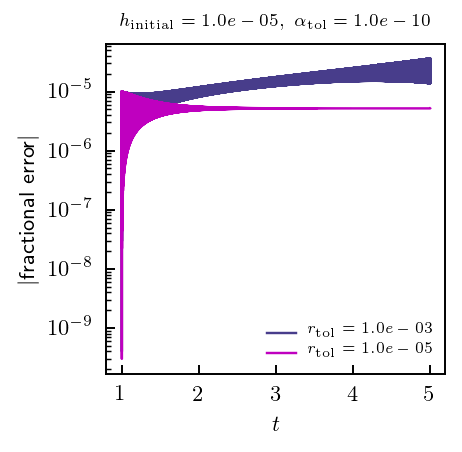

In [12]:
plt.figure(figsize=(2.5,2.5))
plt.yscale('log')
plt.xlabel(r'$t$')
plt.ylabel(r'$|$fractional error$|$')

plt.plot(t_imp_1[1:], frerr_imp_1, lw=1., c='darkslateblue', label=r'$r_{\rm tol} = %.1e$'%(rtol1))
plt.plot(t_imp_2[1:], frerr_imp_2, lw=1., c='m', label=r'$r_{\rm tol} = %.1e$'%(rtol2))

plt.legend(loc='lower right', frameon=False, fontsize=6)
plt.title(r'$h_{\rm initial} = %.1e,\ \alpha_{\rm tol}=%.1e$'%(h, atol), fontsize=7)
plt.show()


### Exercise 2 a

We will know implement a scheme to integrate the N-Body problem. We will use symplectic integration schemes DK, thus for each time step $\tau_n$ it is
$$ \vec{x}_{i}(t_{n+1}) = \vec{x}_{i}(t_{n}) + \tau_n \vec{v}_i(t_{n}) \; , \; \; \vec{v}_{i}(t_{n+1}) = \vec{v}_{i}(t_n) + \tau_n \frac{\vec{F}_{i}(t_n)}{m_i} \; , $$
where $\vec{v}_{i}$ is the velocity of the i-th particle and $\vec{x}_{i}$ its position, while $\vec{F}_{ij}$ is the net gravitational force it feels from all the other bodies in the system.

We will use the following normalization for our variables:
$$r_0 = 1 \; A.U. \; , \; \; t_0 = 100 \; yrs \; , \; \; G = 6.67 \times 10^{-11} \; m^3 \; kg^{-1} \; s^{-2} \; , \; \; m_0 = \frac{r_0^3}{G t_0^2} \; , \; \; a_0 = \frac{r_0}{t_0^2} \; , \; \; v_0 = \frac{r_0}{t_0} \; ,$$
where $a_0$ is the acceleration unit. This setup sets $\tilde{G} = Gm_0t_0r_0^{-3}$ and because we want to write down equations with $\tilde{G} = 1$, we get $t_0 = (r_0^3 G^{-1} m_0^{-1})^{1/2}$. Our dimensionless equations (for a variable or constant $\chi$, we write $\chi = \chi_0 \tilde{\chi}$, where $\chi_0$ is the normalization and $\tilde{\chi}$ what appears in the new equations). In this case, the acceleration is given by
$$\tilde{a}_i = \frac{\tilde{m}_i}{\tilde{r}_{ij}^2} \; ,$$
and therefore, the net force on particle $i$ is
$$\tilde{F}_i = \tilde{m}_i \sum_{j = 1, \; j \neq i}^{N-1} \frac{\tilde{m}_j}{\tilde{r}_{ij}^2}$$
with the normalization $F_0 = m_0 a_0$ for the force.

We are going to use two integration methods to copmare results, 1st order Euler method,
$$\vec{x}_{i}(t_{n+1}) = \vec{x}_{i}(t_{n}) + \tau_n \vec{v}_{i}(t_{n}) \; , \; \; \vec{v}_{i}(t_{n+1}) = \vec{v}_{i}(t_{n}) + \tau_n \frac{ \vec{F}_{i}(t_{n+1}) }{m_i}$$
and the leap-frog 2nd order DKD method,
$$\vec{x}_{i}(t_{n+1}) = \vec{x}_{i}(t_{n}) + \tau_n \vec{v}_{i}(t_{n+1/2}) \; , \; \; \vec{v}_{i}(t_{n+3/2}) = \vec{v}_{i}(t_{n+1/2}) + \tau_n \frac{ \vec{F}_{i}(t_{n+1}) }{m_i} \; .$$

In [13]:
def euler(i, h, x, v, m, G):
    # i: i-th particle (to use in calculation of acceleration)
    # h: time step
    # x, v, a: time, position, velocity, acceleration
    # G, m: gravitational constant, mass
    a = acc(i, x, m, G)
    x[i] += h*v[i]
    v[i] += h*a
    return x[i], v[i]

def leap_frog(i, h, x, v, m, G):
    # i: i-th particle (to use in calculation of acceleration)
    # h: time step
    # x, v, a: time, position, velocity, acceleration
    # G, m: gravitational constant, mass
    x_temp = np.empty(np.shape(x))
    for k in range(len(m)):
        x_temp[k] = x[k] + h*v[k]
    x = x_temp
    a = acc(i, x, m, G)
    v[i] += h*a
    return x[i], v[i]

In [14]:
def remove_i(x, i):
    """
    Drops the ith element of an array
    """
    shape = (x.shape[0]-1,) + x.shape[1:]
    y = np.empty(shape, dtype=float)
    y[:i] = x[:i]
    y[i:] = x[i+1:]
    return y

def acc(i, x, m, G):
    """
    The three components of acelleration of the ith mass
    """
    x_i = x[i]
    x_j = remove_i(x, i) # takes array x and removes element i
    m_j = remove_i(m, i) # same as above for m
    diff = x_j - x_i
    # distances between i-th body and rest of the N-1 bodies
    mag3 = np.sum(diff**2, axis=1)**1.5
    # acceleration of i-th body due to other N-1 bodies
    acceleration = G * np.sum(diff * (m_j / mag3)[:,np.newaxis], axis=0)
    return acceleration

def Etot(i, x, v, m, G):
    
    """Gravitaional potential energy of particle i due all the other particles"""
    x_i = x[i]
    x_j = remove_i(x, i) # takes array x and removes element i
    m_j = remove_i(m, i) # same as above for m
    diff = x_j - x_i
    mag = np.sum(diff**2, axis=1)**0.5
    # acceleration of i-th body due to other N-1 bodies
    potential = - G * np.sum( (m_j / mag)[:,np.newaxis], axis=0)
    potential_energy = m[i] * potential
   
    """Kinetic energy of particle i"""
    kinetic_energy = 0.5*m[i]*np.sum(v[i]*v[i])
    
    return potential_energy + kinetic_energy

In [15]:
""" 
    N-Body integration routine
"""
def nbody_integrate(nsteps, nsample, Np, dt, x, v, m, G0, length, mass, step):
    """
    integrate equations of motions starting from the input vectors x, v, mp
    for nsteps with constant time step dt;

    Parameters: 
    ------------

    nsteps - integer
            the number of steps to take during integration
    nsample - integer
            record physical variables of particles (x, v, and Epot) only each nsample-th step
    nprint  - integer
            print physical quantities every nprint-th step
    dt - float
        step size
    x, v, mp - vectors of floats
         coordinates, velocities and masses of particles
    step - python function
        name of a user-supplied function to compute step using a given stepping scheme
        it should take x, v, mp, dt, dth=dt/2 as inputs

    Etot - python function 
        name of a user-supplied function to compute total energy for input x, v
         it should take into account the difference in time slices of x and v if such
         difference exists
    acc  - python function
        name of a user-supplied function to compute mutual accelerations of particles
        and/or accelerations from an external potential

    Returns:
    -----------------
    tt - numpy float vector
        recorded orbit times
    xt, vt, Ett - numpy float vectors
        coordinates, velocities, and total energies 

    these arrays are initialized as follows: 
        tt  = np.empty(nsteps/nsample+2)
        xt  = np.empty(shape=(nsteps/nsample+2,)+np.shape(x))
        Ett = np.empty(nsteps/nsample+2)
        vt  = np.empty(shape=(nsteps/nsample+2,)+np.shape(x))

"""
    tt  = np.empty(nsteps/nsample)                       # time array
    xt  = np.empty(shape=(nsteps/nsample,)+np.shape(x))  # Cartesian coordinates
    vt  = np.empty(shape=(nsteps/nsample,)+np.shape(x))  # velocity
    x_temp = np.empty(np.shape(x))
    v_temp = np.empty(np.shape(x))
    Et  = np.empty(Np)                                   # total energy (potential + kinetic) at each time
    Ett = np.empty(shape=(nsteps/nsample,)+np.shape(m))  # total energy (potential + kinetic) at sampling times
    """*********************************************************************
    Normalization units: From input constants creates normalization units to
    make equations dimensionless
    *********************************************************************"""
    G  = 1.                      # set G equal to 1
    r0 = length                  # 1 AU will be the unit for distance
    m0 = mass                    # unit mass is the solar mass
    t0 = (r0**3./(G0*m0))**0.5   # time unit (from Kepler's laws)
    """******************************************************************"""
    t = 0; dt /= t0; k = 0
    m /= m0; x /= r0; v /= r0/t0
    tt[0] = t; xt[0] = x; vt[0] = v

    for n in range(1,nsteps) : # loop in time
        for i in range(Np) : # loop over all particles
            # update position, velocity and energy of i-th particle
            x_temp[i], v_temp[i] = step(i, dt, x, v, m, G) # new positions and velocities
        x = x_temp
        v = v_temp
        Et = Etot(i, x, v, m, G) # new energy
        if  n % nsample == 0 : # decide whether to record values or not based on desired sampling frequency
            k += 1
            tt[k] = t; xt[k] = x; vt[k] = v; Ett[k] = Et
        t += dt; n += 1
    return t0*tt, r0*xt, (r0/t0)*vt, (m0*r0**2./t0**2.)*Ett

In [16]:
# parameters and constants
G      = 6.673840000e-11   # gravitational constant in SI units
AU     = 1.495978707e+11   # 1 AU in meters
Msun   = 1.988000000e+30   # mass of Sun in kg
Mearth = 5.972000000e+24   # mass of Earth in kg

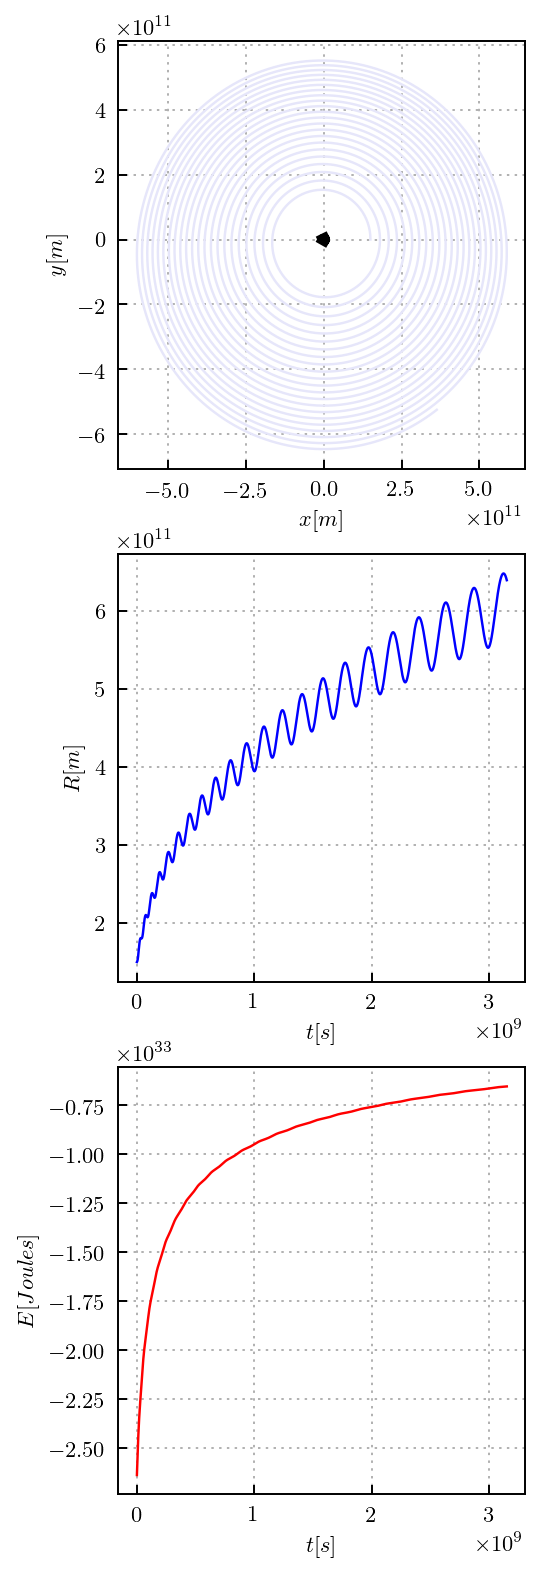

In [17]:
"""
Euler scheme
"""

# number of dimensions, number of particles
D = 3; N = 2

### initialization of x, v, a, m
x = np.zeros((N, D))
v = np.zeros((N, D))
a  = np.zeros((N, D))
m  = np.zeros(N)

### initial coordinates and positions for Euler stepping scheme
### position
x[0] = [0., 0., 0.]   # Sun position
x[1] = [AU, 0., 0.]   # Earth position
### velocity
v[0] = [0., 0., 0.]                   # Sun velocity
v[1] = [0., np.sqrt(G*Msun/AU), 0.]   # Earth velocity

### mass of particles
m[0] = Msun; m[1] = Mearth            # Sun and Earth mass

# time step in seconds
dt = 24*60*60 # one day

# number of time steps, sampling frequency
nsteps = 365*100; nsample = 5

# call the integrator using Euler stepping scheme
tt_euler, xt_euler, vt_euler, Et_euler = nbody_integrate(nsteps, nsample, N, dt, x, v, m, G, AU, Msun, euler)

# euler scheme results
earth_x_euler = np.empty(len(tt_euler))
earth_y_euler = np.empty(len(tt_euler))
earth_z_euler = np.empty(len(tt_euler))
sun_x_euler = np.empty(len(tt_euler))
sun_y_euler = np.empty(len(tt_euler))
sun_z_euler = np.empty(len(tt_euler))
for t in range(len(tt_euler)):
    earth_x_euler[t] = xt_euler[t][1,0]
    earth_y_euler[t] = xt_euler[t][1,1]
    earth_z_euler[t] = xt_euler[t][1,2]
    sun_x_euler[t] = xt_euler[t][0,0]
    sun_y_euler[t] = xt_euler[t][0,1]
    sun_z_euler[t] = xt_euler[t][0,2]
    
# euler scheme radius results
r_euler = np.empty(len(tt_euler))
E_euler = np.empty(len(tt_euler))
for t in range(1,len(tt_euler)):
    r_euler[t] = ( (earth_x_euler[t] - sun_x_euler[t])**2. \
                  + (earth_y_euler[t] - sun_y_euler[t])**2. \
                   + (earth_z_euler[t] - sun_z_euler[t])**2. )**0.5
    E_euler[t] = Et_euler[t,1]
    
# now plot results and 
fig, ax = plt.subplots(3,1, figsize=(3,11))

# plot actual sigma(R) results
ax[0].set_xlabel(r'$x [m]$'); ax[0].set_ylabel(r'$y [m]$')
ax[0].plot(earth_x_euler, earth_y_euler, '-', c='lavender', linewidth=1.)
ax[0].plot(sun_x_euler, sun_y_euler, c='black', linewidth=5.)
ax[0].grid(ls='dotted')

# plot fractional difference from my log integration 
ax[1].set_xlabel(r'$t [s]$'); ax[1].set_ylabel(r'$R [m]$')
ax[1].plot(tt_euler[1:], r_euler[1:], '-', c='b', linewidth=1.)
ax[1].grid(ls='dotted')

# plot fractional difference from my log integration 
ax[2].set_xlabel(r'$t [s]$'); ax[2].set_ylabel(r'$E [Joules]$')
ax[2].plot(tt_euler[1:], E_euler[1:], '-', c='r', linewidth=1.)
ax[2].grid(ls='dotted')

plt.show()

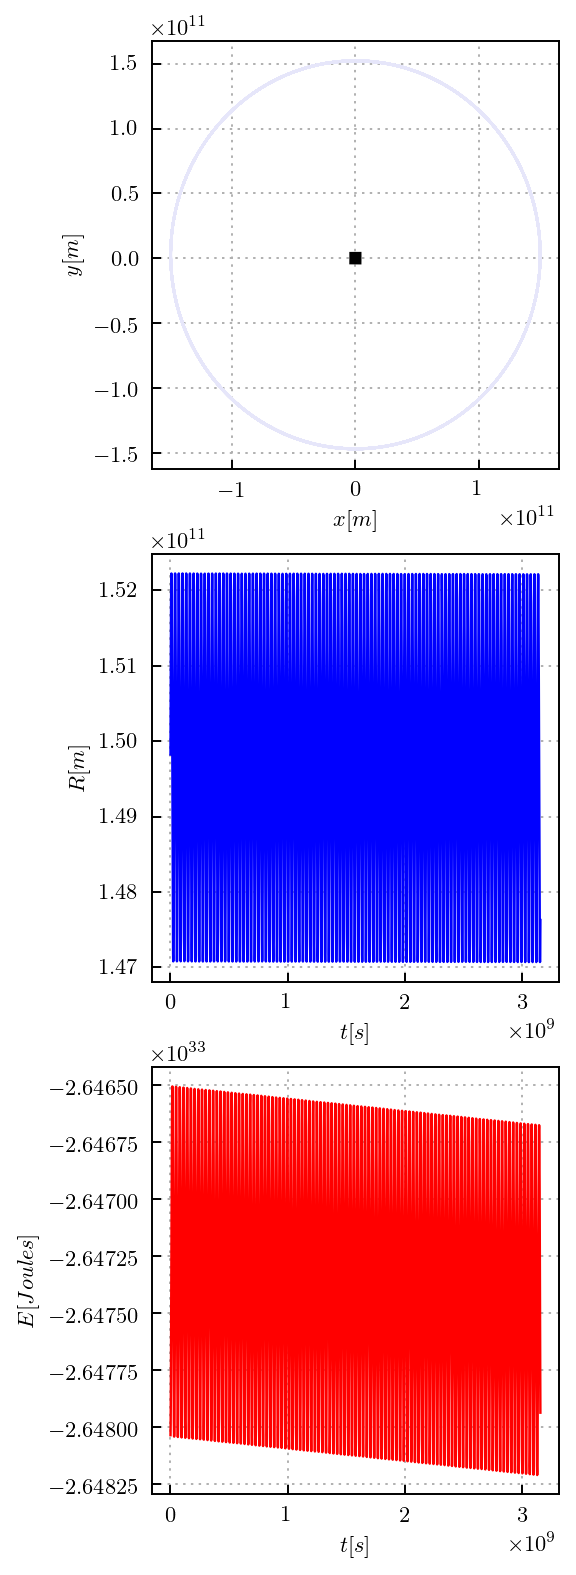

In [18]:
"""
Leapfrog scheme
"""

# number of dimensions, number of particles
D = 3; N = 2

### initialization of x, v, a, m
x = np.zeros((N, D))
v_temp = np.zeros((N, D))
v = np.zeros((N, D))
a  = np.zeros((N, D))
m  = np.zeros(N)

### initial coordinates and positions for Euler stepping scheme
### position
x[0] = [0., 0., 0.]   # Sun position
x[1] = [AU, 0., 0.]   # Earth position
### velocity
v[0] = [0., 0., 0.]                   # Sun velocity
v[1] = [0., np.sqrt(G*Msun/AU), 0.]   # Earth velocity

for i in range(N):
    dum, v[i] = euler(i, 0.5*dt, x, v, m, G)

### mass of particles
m[0] = Msun; m[1] = Mearth            # Sun and Earth mass

# time step in seconds
dt = 24*60*60 # one day

# number of time steps, sampling frequency
nsteps = 365*100; nsample = 5

# call the integrator using leap-frog stepping scheme
tt_frog, xt_frog, vt_frog, Et_frog = nbody_integrate(nsteps, nsample, N, dt, x, v, m, G, AU, Msun, leap_frog)

# leap-frog results
earth_x_frog = np.empty(len(tt_frog))
earth_y_frog = np.empty(len(tt_frog))
earth_z_frog = np.empty(len(tt_frog))
sun_x_frog = np.empty(len(tt_frog))
sun_y_frog = np.empty(len(tt_frog))
sun_z_frog = np.empty(len(tt_frog))
for t in range(len(tt_frog)):
    earth_x_frog[t] = xt_frog[t][1,0]
    earth_y_frog[t] = xt_frog[t][1,1]
    earth_z_frog[t] = xt_frog[t][1,2]
    sun_x_frog[t] = xt_frog[t][0,0]
    sun_y_frog[t] = xt_frog[t][0,1]
    sun_z_frog[t] = xt_frog[t][0,2]
    
# leap-frog scheme radius and energy results
r_frog = np.empty(len(tt_frog))
E_frog = np.empty(len(tt_frog))
for t in range(1,len(tt_frog)):
    r_frog[t] = ( (earth_x_frog[t] - sun_x_frog[t])**2. \
                  + (earth_y_frog[t] - sun_y_frog[t])**2. \
                   + (earth_z_frog[t] - sun_z_frog[t])**2. )**0.5
    E_frog[t] = Et_frog[t,1]
    
# now plot results and 
fig, ax = plt.subplots(3,1, figsize=(3,11))
    
# plot actual sigma(R) results
ax[0].set_xlabel(r'$x [m]$'); ax[0].set_ylabel(r'$y [m]$')
ax[0].plot(earth_x_frog, earth_y_frog, '-', c='lavender', linewidth=1.)
ax[0].plot(sun_x_frog, sun_y_frog, c='black', linewidth=5.)
ax[0].grid(ls='dotted')

# plot fractional difference from my log integration 
ax[1].set_xlabel(r'$t [s]$'); ax[1].set_ylabel(r'$R [m]$')
ax[1].plot(tt_frog[1:], r_frog[1:], '-', c='b', linewidth=1.)
ax[1].grid(ls='dotted')

# plot fractional difference from my log integration 
ax[2].set_xlabel(r'$t [s]$'); ax[2].set_ylabel(r'$E [Joules]$')
ax[2].plot(tt_frog[1:], E_frog[1:], '-', c='r', linewidth=1.)
ax[2].grid(ls='dotted')

plt.show()

As we can see, using the Euler scheme Earth is spiraling outwards over time and its energy increases constantly. This is not the case when implementing the Leapfrog scheme, though. In that case the orbit if the Earth is restricted in a limited spece around the Sun, with its radius from it oscillating without a net change. Also, Earth's energy seems to be oscillating. This difference should be expected since the Leapfrog method is a symplectic integration scheme and conserves the volume in phase space the particles occupy, which makes the scheme stable when integrating over long timescales such a system as the Earth-Sun two-body problem; Euler method does not have this property, making it a bad choice when trying to integrate this system. The energy in this case should not show this net change; this could be fixed by taking into account the difference in time slices when calculating the steps in the leapfrog routine. The N-Body routine took me too long to implement for some reason, though, and I could not find the time to fix that.